In [14]:
from autolens.model.profiles import light_profiles
from autolens.model.profiles import mass_profiles
from autolens.model.galaxy import galaxy
from autolens.lensing import plane
from autolens.imaging import mask
from autolens.lensing.plotters import plane_plotters

# Now we've learnt how to make galaxies out of light and mass profiles, we'll now use galaxies to make a
# strong-gravitational lens. For the newcomers to lensing, a strong gravitation lens is a system where two (or more)
# galaxies align perfectly down our line of sight, such that the foreground galaxy's mass (or mass
# profiles) deflects the light (or light profiles) of the background source galaxies.

# When the alignment is just right, and the lens is just massive enough, the background source galaxy appears multiple
# times. The schematic below shows a crude drawing of such a system, where two light-rays from the source are bending
# around the lens galaxy and into the observer (light should bend 'smoothly', but drawing this on a keyboard wasn't
# possible - so just pretend the diagonal lines coming from the observer and source are less jagged):

#  Observer                  Image-Plane               Source-Plane
#  (z=0, Earth)               (z = 0.5)                (z = 1.0)
#
#           ----------------------------------------------
#          /                                              \ <---- This is one of the source's light-rays
#         /                      __                       \
#    o   /                      /  \                      __
#    |  /                      /   \                     /  \
#   /\  \                      \   /                     \__/
#        \                     \__/                 Source Galaxy (s)
#         \                Lens Galaxy(s)                /
#           \                                           / <----- And this is its other light-ray
#            ------------------------------------------/

# As an observer, we don't see the source's true appearance (e.g. a round blob of light). Instead, we only observe
# its light after it is deflected and lensed by the foreground galaxy's mass. In this exercise, we'll make a source
# galaxy image whose light has been deflected by a lens galaxy.

# In the schematic above, we used the terms 'Image-Plane' and 'Source-Plane'. In lensing speak, a 'plane' is a
# collection of galaxies at the same redshift (that is, parallel to one another down our line-of-sight). Therefore:

# - If two or more lens galaxies are at the same redshift in the image-plane, they deflection light in the same way.
#   This means we can sum their surface-densities, potentials and deflection angles.

# - If two or more source galaxies are at the same redshift in the source-plane, their light is ray-tracing in the
#   same way. Therefore, when determining their lensed images, we can sum the lensed image of each galaxy.

# So, lets do it - lets use the 'plane' module in AutoLens to create a strong lensing system like the one pictured
# above. For simplicity, we'll assume 1 lens galaxy and 1 source galaxy.


In [15]:
# We still need a grid - our grid is effectively the coordinates we 'trace' from the image-plane to the source-plane
# in the lensing configuration above. Our grid is no longer just ouor 'image_grid', but our image-plane grid, so
# lets name as such.
image_plane_grids = mask.ImagingGrids.from_shape_and_pixel_scale(shape=(100, 100), pixel_scale=0.05,
                                                                 sub_grid_size=2)


In [16]:
# Whereas before we called our galaxy's things like 'galaxy_with_light_profile', lets now refer to them by their role
# in lensing, e.g. 'lens_galaxy' and 'source_galaxy'.
mass_profile = mass_profiles.SphericalIsothermal(centre=(0.0,  0.0), einstein_radius=1.6)
lens_galaxy = galaxy.Galaxy(mass=mass_profile)
light_profile = light_profiles.SphericalSersic(centre=(0.0, 0.0), intensity=1.0, effective_radius=1.0, sersic_index=1.0)
source_galaxy = galaxy.Galaxy(light=light_profile)

In [17]:
# Lets setup our image plane. This plane takes the lens galaxy we made above and the grid of image-plane coordinates.
image_plane = plane.Plane(galaxies=[lens_galaxy], grids=[image_plane_grids])

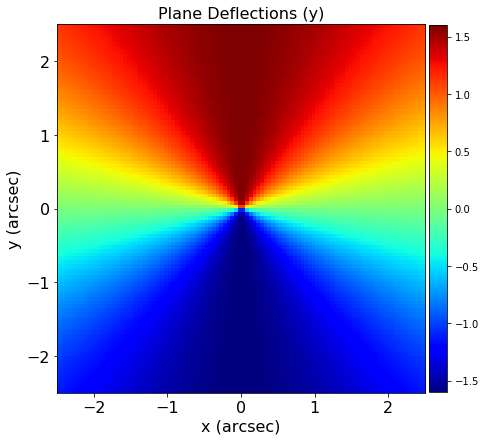

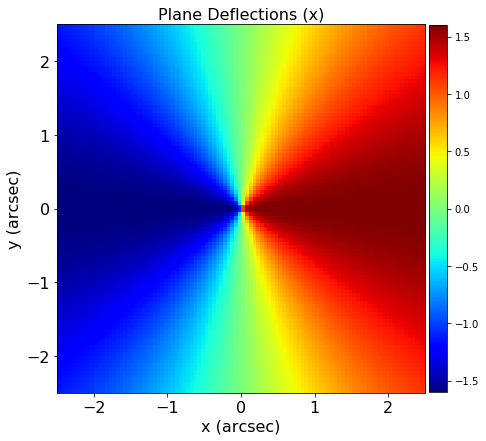

In [18]:
# Up to now, we've kept our light-profiles / mass-profiles / galaxy's and grids separate, and passed the grid to these
# objects to compute quantities (e.g. light_profile.intensities_from_grid(grid=grid)). Plane's combine the two,
# meaning that when we plot a plane's quantities we no longer have to pass the grid.
# Lets have a quick look at our image-plane's deflection angles.
plane_plotters.plot_deflections_y(plane=image_plane)
plane_plotters.plot_deflections_x(plane=image_plane)

In [19]:
# Throughout this chapter, so plotted a lot of deflection angles. However, if you arn't familiar with strong lensing,
# you probably weren't entirely sure what they were for. The deflection angles tell us how light is 'lensed' by a
# lens galaxy. By taking the image-plane coordinates and deflection angles, we can subtract the two to determine
# our source-plane's lensed coordinates, e.g.

# source_plane_grids = image_plane_grids - image_plane_deflection_angles

# Therefore, we can use our image_plane to 'trace' its grids to the source-plane...
source_plane_grids = image_plane.trace_grids_to_next_plane()


In [20]:
# ... and use these grids to setup our source-plane
source_plane = plane.Plane(galaxies=[source_galaxy], grids=source_plane_grids)

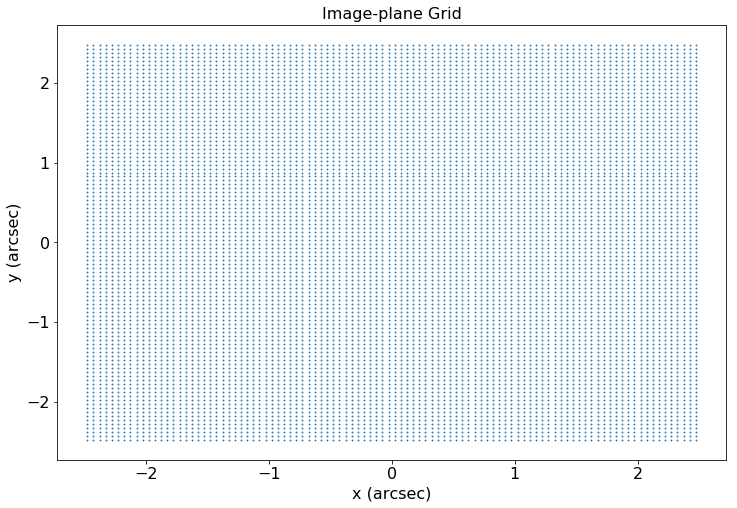

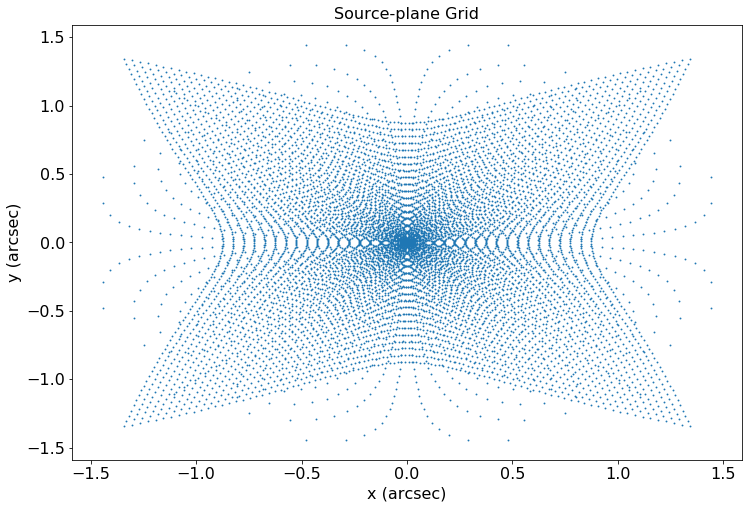

In [23]:
# Lets inspect our grids - I bet our source-plane isn't the boring uniform grid we plotted in the first tutorial!
plane_plotters.plot_plane_grid(plane=image_plane, title='Image-plane Grid')
plane_plotters.plot_plane_grid(plane=source_plane, title='Source-plane Grid')

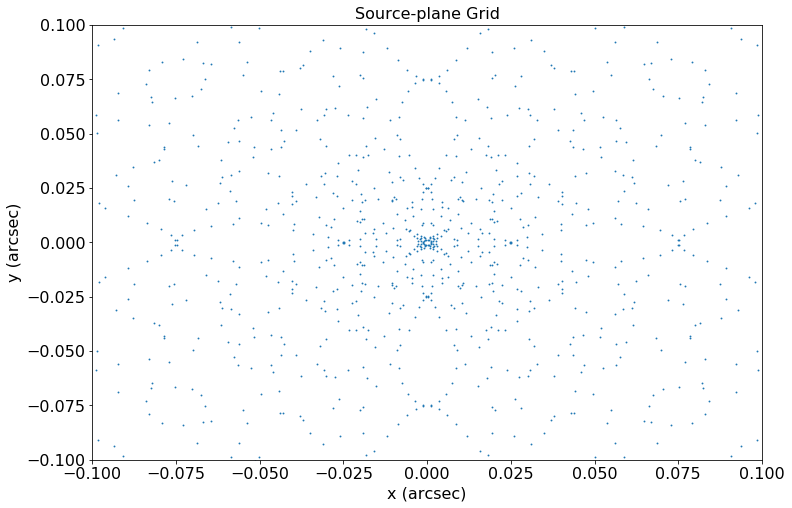

In [24]:
# We can zoom in on the 'centre' of the source-plane (remembering the lens galaxy was centred at (0.1, 0.1)
plane_plotters.plot_plane_grid(plane=source_plane, axis_limits=[-0.1, 0.1, -0.1, 0.1], title='Source-plane Grid')

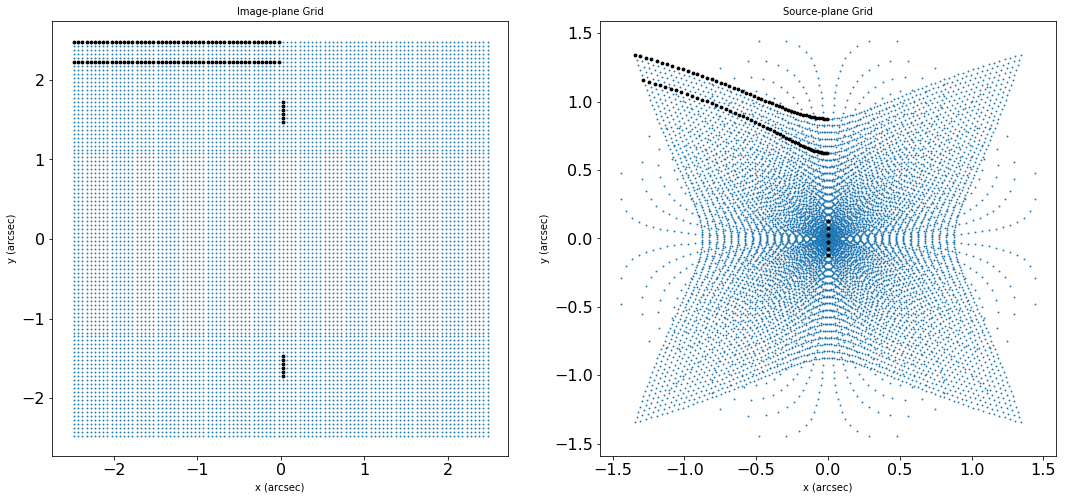

In [25]:
# We can also plot both planes next to one another, and highlight specific points on the grids. This means we can see
# how different image pixels map to the source-plane.
# (We are inputting the pixel index's into 'points' - the first set of points go from 0 -> 50, which is the top row of
# the image-grid running from the left - as we said it would!)
plane_plotters.plot_image_and_source_plane_subplot(image_plane=image_plane, source_plane=source_plane,
    points=[[range(0,50)], [range(500, 550)],
            [1550, 1650, 1750, 1850, 1950, 2050],
            [8450, 8350, 8250, 8150, 8050, 7950]])

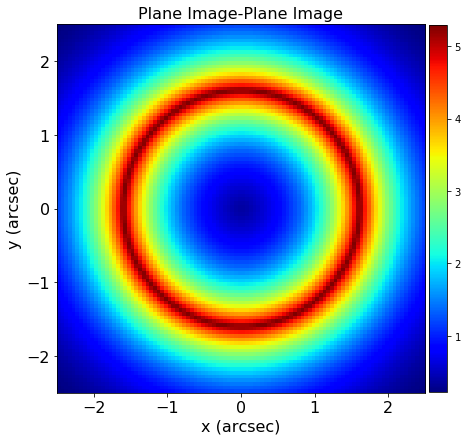

In [26]:
# Clearly, the source-plane has a very different grid to the image-plane. It's not uniform, its not regular and well,
# its not boring!

# We can now ask the question - 'what does our source-galaxy look like in the image-plane'? That is, to us, the
# observer on Earth, how do we see the source-galaxy (after it is lensed). To do this, we simply imaging the source
# galaxy's light 'mapping back' from the lensed source-plane grid above.
plane_plotters.plot_image_plane_image(plane=source_plane)

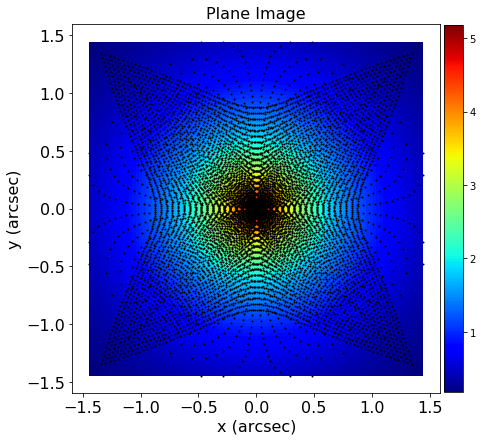

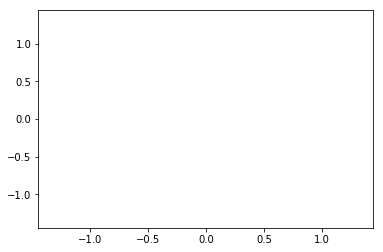

In [27]:
# It's a rather spectacular ring of light, but why is it a ring? Well:

# - Our lens galaxy was centred at (0.0", 0.0").
# - Our source-galaxy was centred at (0.0", 0.0").
# - Our lens galaxy had a spherical mass-profile.
# - Our source-galaxy a spherical light-profile.
#
# Given the perfect symmetric of the system, every path the source's light take around the lens galaxy must be
# radially identical. This, nothing else but a ring of light can form!

# This is called an 'Einstein Ring' and its radius is called the 'Einstein Radius', which are both named after the
# man who famously used gravitational lensing to prove his theory of general relativity.

# Finally, because we know our source-galaxy's light profile, we can also plot its 'plane_image'. This is how the
# source intrinsically appears in the source-plane (e.g. without lensing). This is a useful thing to know, because
# the source-s light is highly magnified, meaning as astronomers we can study it in a lot more detail than would
# otherwise be possible!
plane_plotters.plot_plane_image(plane=source_plane)

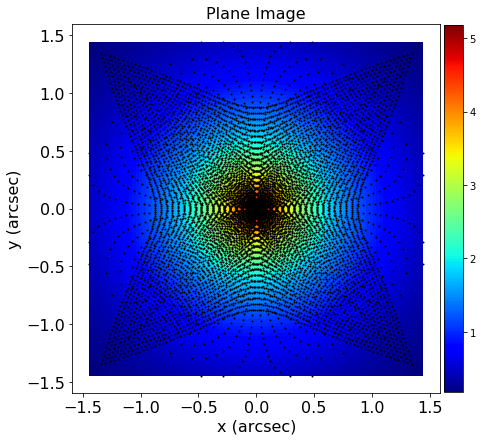

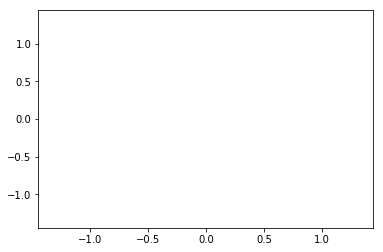

In [28]:
# Plotting the grid over the plane image obscures its appearance, which isn't ideal. However, later in the tutorials, 
# you'll notice that this issue goes away.
plane_plotters.plot_plane_image(plane=source_plane, plot_grid=True)

In [12]:
# And, we're done. This is the first tutorial covering actual strong-lensing and I highly recommend you take a moment
# to really mess about with the code above to see what sort of lensed images you can form. Pay attention to the
# source-plane grid - its appearance can change quite a lot!
#
# In particular, try:

# 1) Change the lens galaxy's einstein radius - what happens to the source-plane's image-plane image?

# 2) Change the SphericalIsothermal mass-profile to an EllipticalIsothermal mass-profile and set its axis_ratio to 0.8.
#    What happens to the number of source images?

# 3) As discussed at the beginning, planes can be composed of multiple galaxies. Make an the image-plane with two
#    galaxies and see how multi-galaxy lensing leads to crazy source image-plane images. Also try making a source-plane
#    with two galaxies!

# Finally, if you are a newcomer to strong lensing, it might be worth reading briefly about some strong lensing theory.
# Don't worry about maths, and equations, and anything scary, but you should at least go to Wikipedia to figure out:

# - What a critical line is.

# - What a caustic is.

# - What determines the image multiplicity of the lensed source.